# PARETO - Strategic Model Demo
The purpose of this Jupyter notebook is to provide a demonstration of PARETO's strategic model. This demo will show how to use PARETO's Python coding interface. If you prefer a graphical interface, you can download the PARETO GUI [here](https://www.project-pareto.org/software/).

## Introduction
This demo is based on PARETO's strategic toy case study. Relevant links:
- [Strategic model documentation](https://pareto.readthedocs.io/en/latest/model_library/strategic_water_management/index.html)
- [Documentation of PARETO case studies](https://pareto.readthedocs.io/en/latest/case_studies/index.html)

The strategic toy case study features a very small produced water network. This network is smaller than most realistic produced water networks, but the small size of this example makes it useful for testing, debugging, demonstrations, etc. Below is a schematic image of the strategic toy network:

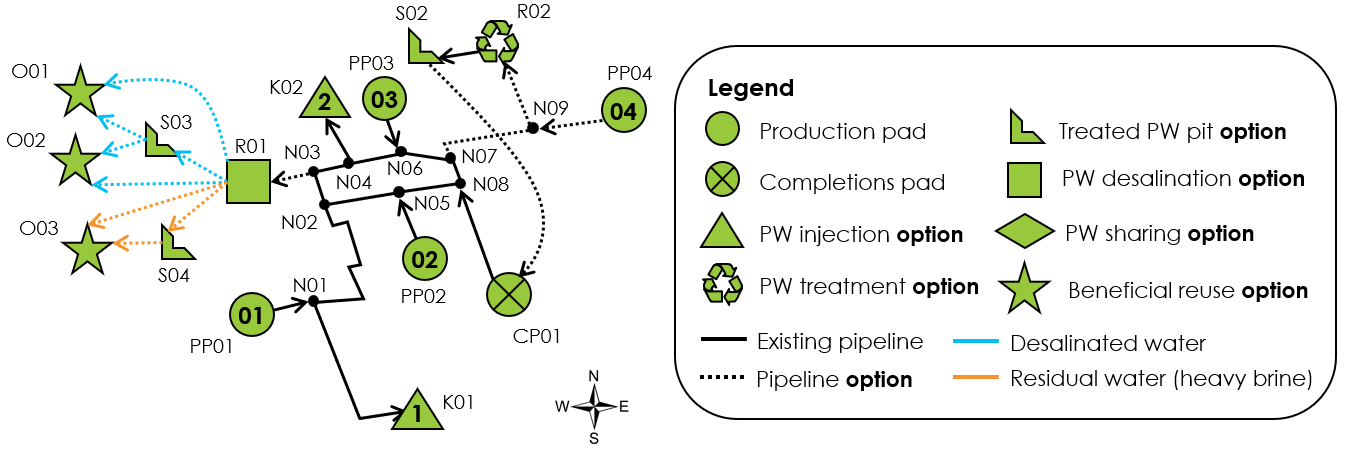

Please note that the strategic toy case study data is arbitrary, but meant to be representative of a real produced water network. We will now proceed with demonstrating all of the steps that are needed to set up and solve an instance of PARETO's strategic model.

The rest of this demonstration will proceed in six steps:
1. [Import needed files and libraries](#import)
2. [Load data into Python](#load_data)
3. [Build the Pyomo model](#build)
4. [Solve the model](#solve)
5. [Analyze results](#analyze)
6. [Hydraulics module](#hydraulics)

Note that PARETO includes a file called `run_strategic_model.py` which is a ready-to-go script that can be used to run a PARETO case study with default options. The steps which are described in this notebook are essentially the same as those that are used in `run_strategic_model.py`.

## <a id='import'></a>Step 1: Import needed files and libraries
To begin, ensure that you are working in a development environment where PARETO is installed. For example, if you followed the PARETO [installation instructions](https://pareto.readthedocs.io/en/latest/getting_started/index.html) to create a conda environment called `pareto-env`, then make sure that environment is active by running `conda activate pareto-env`.

The first thing we do in Python is import all necessary modules and functions:

In [ ]:
#####################################################################################################
# PARETO was produced under the DOE Produced Water Application for Beneficial Reuse Environmental
# Impact and Treatment Optimization (PARETO), and is copyright (c) 2021-2024 by the software owners:
# The Regents of the University of California, through Lawrence Berkeley National Laboratory, et al.
# All rights reserved.
#
# NOTICE. This Software was developed under funding from the U.S. Department of Energy and the U.S.
# Government consequently retains certain rights. As such, the U.S. Government has been granted for
# itself and others acting on its behalf a paid-up, nonexclusive, irrevocable, worldwide license in
# the Software to reproduce, distribute copies to the public, prepare derivative works, and perform
# publicly and display publicly, and to permit others to do so.
#####################################################################################################

from pareto.strategic_water_management.strategic_produced_water_optimization import (
    WaterQuality,
    create_model,
    Objectives,
    solve_model,
    PipelineCost,
    PipelineCapacity,
    Hydraulics,
    RemovalEfficiencyMethod,
    InfrastructureTiming,
)
from pareto.utilities.get_data import get_data
from pareto.utilities.results import (
    plot_bars,
    plot_sankey,
    generate_report,
    PrintValues,
    OutputUnits,
    is_feasible,
    nostdout,
)
from importlib import resources

## <a id='load_data'></a>Step 2: Load data into Python
The data defining the produced water network is stored in an Excel workbook (often referred to as the "input file"). Some of the tabs in the input file define index sets for the model, whereas other tabs contain the parameter data that will used to build the model.

A rather large amount of data can be provided by the user. When the model is built, a series of data checks are performed. Errors are raised for missing essential data and warnings are raised for missing data that is populated with defaults and extra input data that is not parsed. We will not attempt to summarize all of the data input requirements here, but we refer the reader to the [strategic model documentation](https://pareto.readthedocs.io/en/latest/model_library/strategic_water_management/index.html) to learn more. You can also download several example input files from GitHub [here](https://github.com/project-pareto/project-pareto/tree/main/pareto/case_studies). Note that `strategic_toy_case_study.xlsx` is the input file which will be used in this demo.

PARETO's `get_data` utility function ([documentation](https://pareto.readthedocs.io/en/latest/utilities/Get_Data.html#get-data-get-data)) called below reads the data from the input file into the `df_sets` and `df_parameters` variables. The variables `df_sets` and `df_parameters` which are returned are dictionaries where the keys are the workbook tab names and the values are either dictionaries or Pandas dataframe objects containing the data read from the corresponding workbook tab. By default `get_data` will only read approved PARETO input tabs. Custom data tabs can optionally be passed to the function, Step 5 demonstrates an example of customizing `get_data` to read PARETO output files. Note: If custom data tabs are passed, the data is not incorporated into the PARETO model unless the models are modified. 

In [ ]:
# Load data from Excel input file into Python
with resources.path(
    "pareto.case_studies",
    "strategic_toy_case_study.xlsx",
) as fpath:
    [df_sets, df_parameters] = get_data(fpath)

### Step 2.1 (optional): Display input data
A simple way to view the input data is to print members from `df_sets` and `df_parameters`:

In [ ]:
print("------- Production pads -------")
print(type(df_sets["ProductionPads"]))
print(df_sets["ProductionPads"])

print("\n------- Completions demand -------")
print(type(df_parameters["CompletionsDemand"]))
print(df_parameters["CompletionsDemand"])

print("\n------- Desalination technologies -------")
print(type(df_parameters["DesalinationTechnologies"]))
print(df_parameters["DesalinationTechnologies"])

PARETO's `plot_bars` function ([documentation](https://pareto.readthedocs.io/en/latest/utilities/Results.html#plot-bars)) can be used to create bar charts. If the plotted variable is indexed by time, then a dynamic, animated chart is created:

In [ ]:
input_data = {
    "pareto_var": df_parameters["PadRates"],
    "labels": [("Production pad", "Time", "Production forecast (bbl/day)")],
}
args = {
    "plot_title": "Production forecast",
    "output_file": "demo_bar.html",
    "print_data": False,
}
fig = plot_bars(input_data, args)
fig.update_layout(width=1000, height=500)
fig  # Display bar chart in Jupyter notebook

## <a id='build'></a>Step 3: Build the Pyomo model
PARETO's `create_model` function called below uses the [Pyomo](http://www.pyomo.org/) modeling language to build a mathematical model of the produced water network. There are eight different settings which can be specified for building the model:

| Setting | Possible values (default in *italics*) |
| :- | :- |
| `objective` | *`Objectives.cost`* - minimize the total annualized cost of produced water management over the decision horizon<br><br>`Objectives.reuse` - maximize the amount of produced water that is reused over the decision horizon<br><br>`Objectives.cost_surrogate` - minimize the total annualized cost of produced water management over the decision horizon when using a surrogate model for desalination<br><br>`Objectives.subsurface_risk` - minimize the total amount of risk incurred from SWD injection<br><br>`Objectives.environmental` - minimize the total emissions incurred from produced water management |
| `pipeline_cost` | *`PipelineCost.capacity_based`* - use pipeline capacities and rate in [currency/volume] to calculate pipeline CAPEX costs<br><br>`PipelineCost.distance_based` - use pipeline distances and rate in [currency/(diameter-distance)] to calculate pipeline CAPEX costs |
| `pipeline_capacity` | *`PipelineCapacity.input`* - flow capacity for each pipe diameter is provided by the user<br><br>`PipelineCapacity.calculate` - flow capacity for each pipe diameter is calculated based on the diameter and provided pipe hydraulics data |
| `node_capacity` | *`True`* - include upper bound on network node flow capacity <br><br>`False` - exclude upper bound on network node flow capacity |
| `water_quality` | *`WaterQuality.post_process`* - calculate water quality throughout the network post-optimization<br><br>`WaterQuality.false` - exclude any water quality calculations from the model<br><br>`WaterQuality.discrete` - discretize the water quality variables to include in the optimization model |
| `removal_efficiency_method` | `RemovalEfficiencyMethod.load_based` - treatment component removal efficiency is based on the total load of quality components<br><br>*`RemovalEfficiencyMethod.concentration_based`* - treatment component removal efficiency is based on concentration reduction <br><br>NOTE: The choice for `removal_efficiency_method` has no effect if `water_quality` is set to `WaterQuality.false`. |
| `hydraulics` | *`Hydraulics.false`* - do not add hydraluics to model<br><br>`Hydraulics.post_process` - add hydraulics information to the model post-optimization<br><br>`Hydraulics.co_optimize` - use an MINLP formulation to include hydraulics in the optimization model<br><br>`Hydraulics.co_optimize_linearized` - a linearized approximation of the hydraulics co-optimization model |
| `infrastructure_timing` | *`InfrastructureTiming.false`* - exclude infrastructure timing in model<br><br>`InfrastructureTiming.true` - include infrastructure timing in model |
| `desalination_model` | *`DesalinationModel.false`* - do not use a surrogate model for desalination<br><br>`DesalinationModel.mvc` - use mechanical vaport compression (MVC) surrogate model for desalination<br><br>`DesalinationModel.md` - use membrane distillation (MD) surrogate model for desalination |
| `subsurface_risk` | *`SubsurfaceRisk.false`* - exclude subsurface risk from model (unless the subsurface risk objective function is selected)<br><br>`SubsurfaceRisk.exclude_over_and_under_pressured_wells` - calculate subsurface risk metrics and disallow disposal to overpressured and underpressured wells<br><br>`SubsurfaceRisk.calculate_risk_metrics` - calculate subsurface risk metrics for the user to view, but don't change the optimization model |

In [ ]:
# Create Pyomo optimization model representing the produced water network
strategic_model = create_model(
    df_sets,
    df_parameters,
    default={
        "objective": Objectives.cost,
        "pipeline_cost": PipelineCost.distance_based,
        "pipeline_capacity": PipelineCapacity.input,
        "hydraulics": Hydraulics.post_process,
        "node_capacity": True,
        "water_quality": WaterQuality.false,
        "removal_efficiency_method": RemovalEfficiencyMethod.concentration_based,
        "infrastructure_timing": InfrastructureTiming.true,
    },
)

## <a id='solve'></a>Step 4: Solve the model
PARETO's `solve_model` function called below solves the model with the provided options. There are seven different options which can be passed:

| Option | Description | Default value |
| :- | :- | :- |
| `solver` | Either a string with solver name or a tuple of strings with several solvers to try and load in order. PARETO currently supports Gurobi (commercial), CPLEX (commercial) and CBC (free) solvers, but it might be possible to use other MILP solvers as well. | `("gurobi_direct", "gurobi", "gams:CPLEX", "cbc")` |
| `deactivate_slacks` | `True` to deactivate slack variables, `False` to use slack variables. | `True` |
| `scale_model` | `True` to apply scaling to the model, `False` to not apply scaling. | `False` |
| `scaling_factor` | Scaling factor to apply to the model (only relevant if `scale_model` is `True`). | 1000000 |
| `running_time` | Maximum solver running time in seconds. | 60 |
| `gap` | Solver gap. | 0 |
| `gurobi_numeric_focus` | The `NumericFocus` parameter to pass to the Gurobi solver. This parameter can be 1, 2, or 3, and per Gurobi, "settings 1-3 increasingly shift the focus towards more care in numerical computations, which can impact performance." This option is ignored if a solver other than Gurobi is used. | 1 |
| `only_subsurface_block` | If `True`, solve only the subsurface risk block and then return without solving the parent model. This option only has an affect if the subsurface risk block has been created. | `False` |

In [ ]:
# Solve Pyomo model with specified options
options = {
    "solver": ("gurobi", "cbc"),
    "deactivate_slacks": True,
    "scale_model": False,
    "scaling_factor": 1000000,
    "running_time": 300,
    "gap": 0,
    "gurobi_numeric_focus": 1,
}
results = solve_model(model=strategic_model, options=options)

PARETO's `is_feasible` utility function can be called after solving the model to check whether or not the solution returned by the solver violates any constraints:

In [ ]:
# Check feasibility of the solved model.
with nostdout():
    feasibility_status = is_feasible(strategic_model)
if not feasibility_status:
    print("Model results are not feasible and should not be trusted")
else:
    print("Model results validated and found to pass feasibility tests")

## <a id='analyze'></a>Step 5: Analyze results
PARETO's `generate_report` function ([documentation](https://pareto.readthedocs.io/en/latest/utilities/Results.html#generate-report)) can be used to export the optimization reports to an Excel report. The first argument to the function is the model itself, and then there are four optional keyword arguments:

| Option | Description | Default value |
| :- | :- | :- |
| `results_obj` | The object returned by the solver. If provided, this object is used to extract data from the solver to include in the report. | `None` |
| `is_print` | Determines how many results to print to the console, but has no effect on what is included in the Excel report. There are four possible values that may be passed:<br><br>- `None`<br><br>- `PrintValues.detailed`<br><br>- `PrintValues.nominal`<br><br>- `PrintValues.essential`<br><br>Note that it will be a rare case where it is useful or desirable to pick something other than `None` or `PrintValues.essential` for this option. | `None` |
| `output_units` | Determines whether the units used in the report are the units provided by the user or the internal units used by the model. Specifically, the values that may be passed are:<br><br>- `OutputUnits.unscaled_model_units`<br><br>- `OutputUnits.user_units` | `OutputUnits.user_units` |
| `fname` | The file name for the generated Excel report. | `"PARETO_report.xlsx"` |

In [ ]:
# Generate report with results in Excel
[model, results_dict] = generate_report(
    strategic_model,
    results_obj=results,
    is_print=PrintValues.essential,
    output_units=OutputUnits.user_units,
    fname="strategic_optimization_results.xlsx",
)

The `get_data` function is primarily designed to read PARETO input files, but it can also be used to load data from a previously generated PARETO results report. Because generated reports are not valid PARETO input, the desired tabs to be read must be explicitly passed to `get_data`. The function raises a warning for tabs in the Excel file that are not read in. These tabs are invalid PARETO input tabs that are not explicitly passed to `get_data`. Warnings are expected when reading in PARETO results reports:

In [ ]:
# Read data from the PARETO results report
tabs_to_read = ["v_F_Overview", "vb_y_overview", "v_F_Sourced"]
fname = "strategic_optimization_results.xlsx"
_, parameters_report = get_data(fname, [], tabs_to_read)

print("------- Overview -------")
print(
    parameters_report["v_F_Overview"]
)  # Note that this is the same data that was printed above by the generate_report function
print("\n------- Infrastructure buildout overview -------")
print(parameters_report["vb_y_overview"])
print("\n------- Sourced water -------")
print(parameters_report["v_F_Sourced"])

### Step 5.1 (optional): Generate Sankey diagrams
PARETO's `plot_sankey` function ([documentation](https://pareto.readthedocs.io/en/latest/utilities/Results.html#generate-sankey)) can be used to generate Sankey diagrams of the output:

In [ ]:
input_data = {
    "pareto_var": results_dict["v_F_Piped_dict"],
    "time_period": "T01",
}
args = {
    "plot_title": "Piped water - T01",
    "output_file": "demo_sankey_T01.html",
}
fig = plot_sankey(input_data, args)
fig.update_layout(width=1000, height=500)
fig  # Display Sankey diagram in Jupyter notebook

Note that the Sankey diagram is interactive - try hovering your mouse over different elements of the diagram, and clicking and dragging!

We can pass a list of time period indices for the `time_period` entry in the `input_data` argument to get a Sankey diagram showing the cumulative flows over the specified time periods:

In [ ]:
input_data = {
    "pareto_var": results_dict["v_F_Piped_dict"],
    "time_period": ["T01", "T02"],
}
args = {
    "plot_title": "Piped water - T01 and T02",
    "output_file": "demo_sankey_T01_T02.html",
}
fig = plot_sankey(input_data, args)
fig.update_layout(width=1000, height=500)
fig  # Display Sankey diagram in Jupyter notebook

If we omit the `time_period` entry entirely, then the flows shown in the Sankey diagram are cumulative for the entire time horizon:

In [ ]:
input_data = {"pareto_var": results_dict["v_F_Piped_dict"]}
args = {
    "plot_title": "Piped water - all times",
    "output_file": "demo_sankey_all_times.html",
}
fig = plot_sankey(input_data, args)
fig.update_layout(width=1000, height=500)
fig  # Display Sankey diagram in Jupyter notebook

By passing a `sections` entry in the `input_data` argument, we can create separate Sankey diagrams for different subsections of the overall network: 

In [ ]:
input_data = {
    "pareto_var": results_dict["v_F_Piped_dict"],
    "sections": {
        "Section1": ["N01", "N02", "N03", "N04"],
        "Section2": ["N05", "N06", "N07", "N08", "N09"],
    },
    "time_period": "T01",
}
args = {
    "plot_title": "Piped water - T01",
    "output_file": "demo_sankey_T01_sections.html",
}
figs = plot_sankey(input_data, args)
figs[0].update_layout(width=1000, height=500)
figs[0]  # Display first Sankey diagram in Jupyter notebook

In [ ]:
figs[1].update_layout(width=1000, height=500)
figs[1]  # Display second Sankey diagram in Jupyter notebook

## <a id='hydraulics'></a>Hydraulics module
The model we previously created and solved used the configuration option `Hydraulics.post_process`, which means that hydraulics calculations are performed after the main optimization. Next, we create and solve a model for the same produced water network which incorporates hydraulics calculations into the optimization problem. There are two options which can be used to this end. `Hydraulics.co_optimize` is the more rigorous option, which forms a mixed-integer nonlinear program (MINLP). This kind of problem can be difficult to solve, so PARETO also includes the option `Hydraulics.co_optimize_linearized`, which implements a linearized approximation of the MINLP model. Retaining linearity for the model significantly increases tractability.

In this notebook, we use the `Hydraulics.co_optimize_linearized` option. Note that if you are using the solver CBC, running the following code block may timeout due to the solver failing to reach optimality in the allotted time. If necessary, you can increase the `"running_time"` option for the solver shown previously and re-run the notebook.

In [ ]:
# Create Pyomo optimization model representing the produced water network with hydraulics co-optimization
strategic_model_co = create_model(
    df_sets,
    df_parameters,
    default={
        "objective": Objectives.cost,
        "pipeline_cost": PipelineCost.distance_based,
        "pipeline_capacity": PipelineCapacity.input,
        "hydraulics": Hydraulics.co_optimize_linearized,
        "node_capacity": True,
        "water_quality": WaterQuality.false,
        "removal_efficiency_method": RemovalEfficiencyMethod.concentration_based,
        "infrastructure_timing": InfrastructureTiming.true,
    },
)

results_co = solve_model(model=strategic_model_co, options=options)

We check the feasibility of the model and compare the costs of the two models:

In [ ]:
# Check feasibility of the solved model.
with nostdout():
    feasibility_status = is_feasible(strategic_model_co)
if not feasibility_status:
    print("Model results are not feasible and should not be trusted")
else:
    print("Model results validated and found to pass feasibility tests")

print(
    "\nHydraulics.post_process pump/valve cost: ",
    strategic_model.hydraulics.v_Z_HydrualicsCost.value,
)
print(
    "Hydraulics.post_process total cost: ",
    strategic_model.v_Z.value + strategic_model.hydraulics.v_Z_HydrualicsCost.value,
)
print(
    "Hydraulics.co_optimize_linearized pump/valve cost: ",
    strategic_model_co.hydraulics.v_Z_HydrualicsCost.value,
)
print(
    "Hydraulics.co_optimize_linearized total cost: ",
    strategic_model_co.v_Z.value
    + strategic_model_co.hydraulics.v_Z_HydrualicsCost.value,
)

The hydraulics module calculates the pressure profile across the network at all times:

In [ ]:
# Pick a time and print the pressures across the network
t = strategic_model.s_T.at(10)

print("Pressures for post_process solution across network at time", t)
for l in strategic_model.s_L:
    print(l, ":", strategic_model.hydraulics.v_Pressure[l, t].value)

print("\nPressures for co_optimize solution across network at time", t)
for l in strategic_model_co.s_L:
    print(l, ":", strategic_model_co.hydraulics.v_Pressure[l, t].value)

The hydraulics module also recommends locations for pump installations:

In [ ]:
# Print pump locations in the network
print("Pump locations for post_process method")
for l1, l2 in strategic_model.s_LLA:
    if strategic_model.hydraulics.vb_Y_Pump[l1, l2].value == 1:
        print("Pump installed between", l1, "and", l2)

print("\nPump locations for co_optimize method")
for l1, l2 in strategic_model_co.s_LLA:
    if strategic_model_co.hydraulics.vb_Y_Pump[l1, l2].value == 1:
        print("Pump installed between", l1, "and", l2)

## Conclusion
We hope this demonstration of PARETO's strategic model has been helpful and informative. If you have any questions, comments, or feedback for the PARETO team, please do not hesitate to [contact us](https://www.project-pareto.org/team/contact-us/).